In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
''' reading dataset '''
df = pd.read_csv('candy_production.csv')

In [3]:
''' dispalying first 5 rows '''
df.head()

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


In [4]:
''' dispalying last 5 rows '''
df.tail()

,observation_date,IPG3113N
543,2017-04-01,107.4288
544,2017-05-01,101.9209
545,2017-06-01,104.2022
546,2017-07-01,102.5861
547,2017-08-01,114.0613


In [5]:
''' making observation_date as index of df '''
df = df.rename(columns={'observation_date': 'date', 'IPG3113N': 'production'})
df.index = pd.DatetimeIndex(data=df.date)
df.drop(columns=['date'], inplace=True)

In [6]:
df.head()

,production
date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [7]:
''' checking null values '''
df.isnull().sum()

production    0
dtype: int64

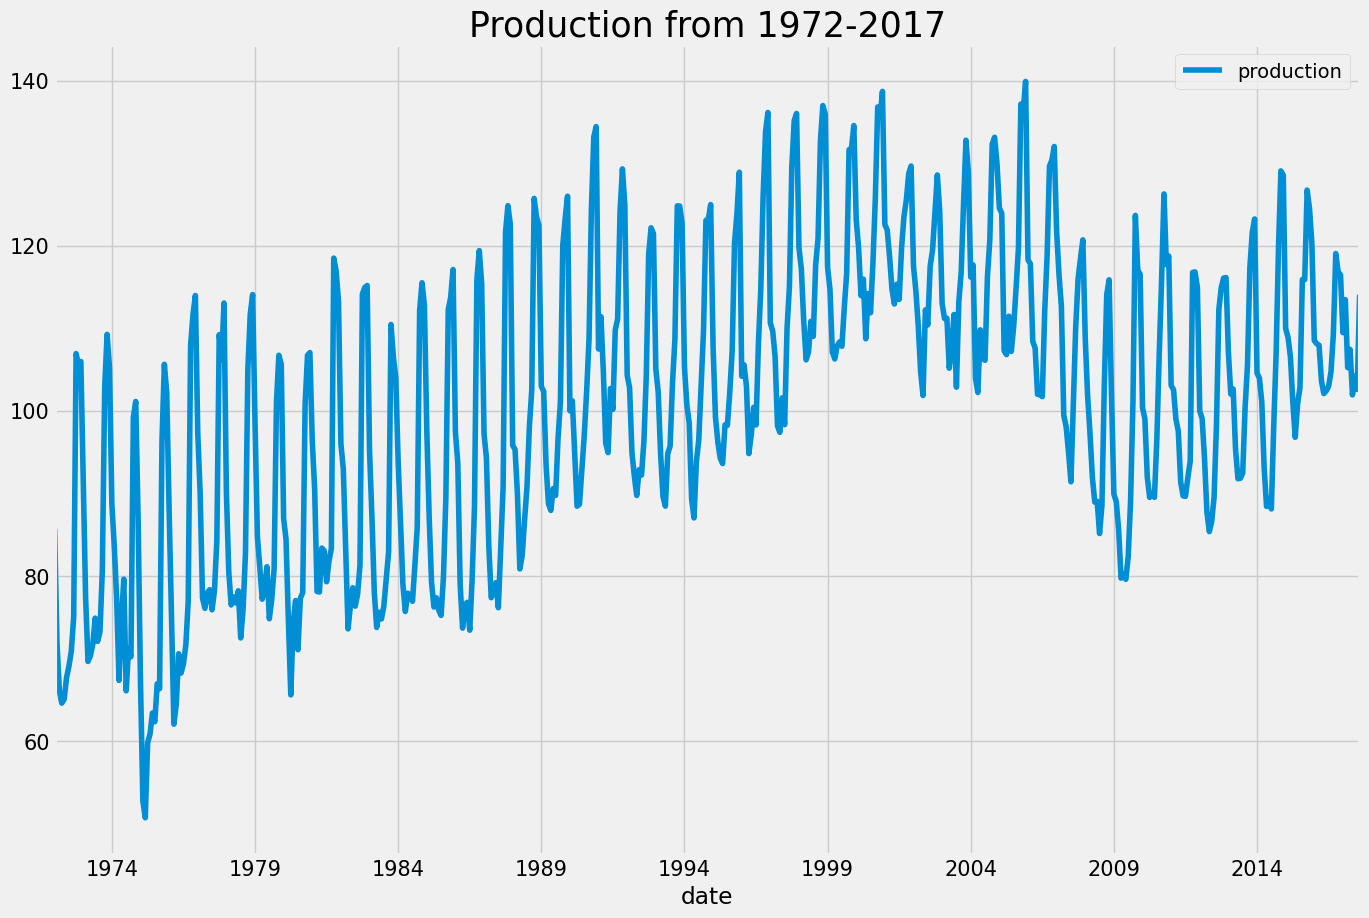

In [8]:
''' checking seasonality of data  '''
df.plot(figsize=(15, 10), fontsize=15)
plt.title('Production from 1972-2017', fontsize=25)
plt.show()

Lambda Value 1.2550906935610247


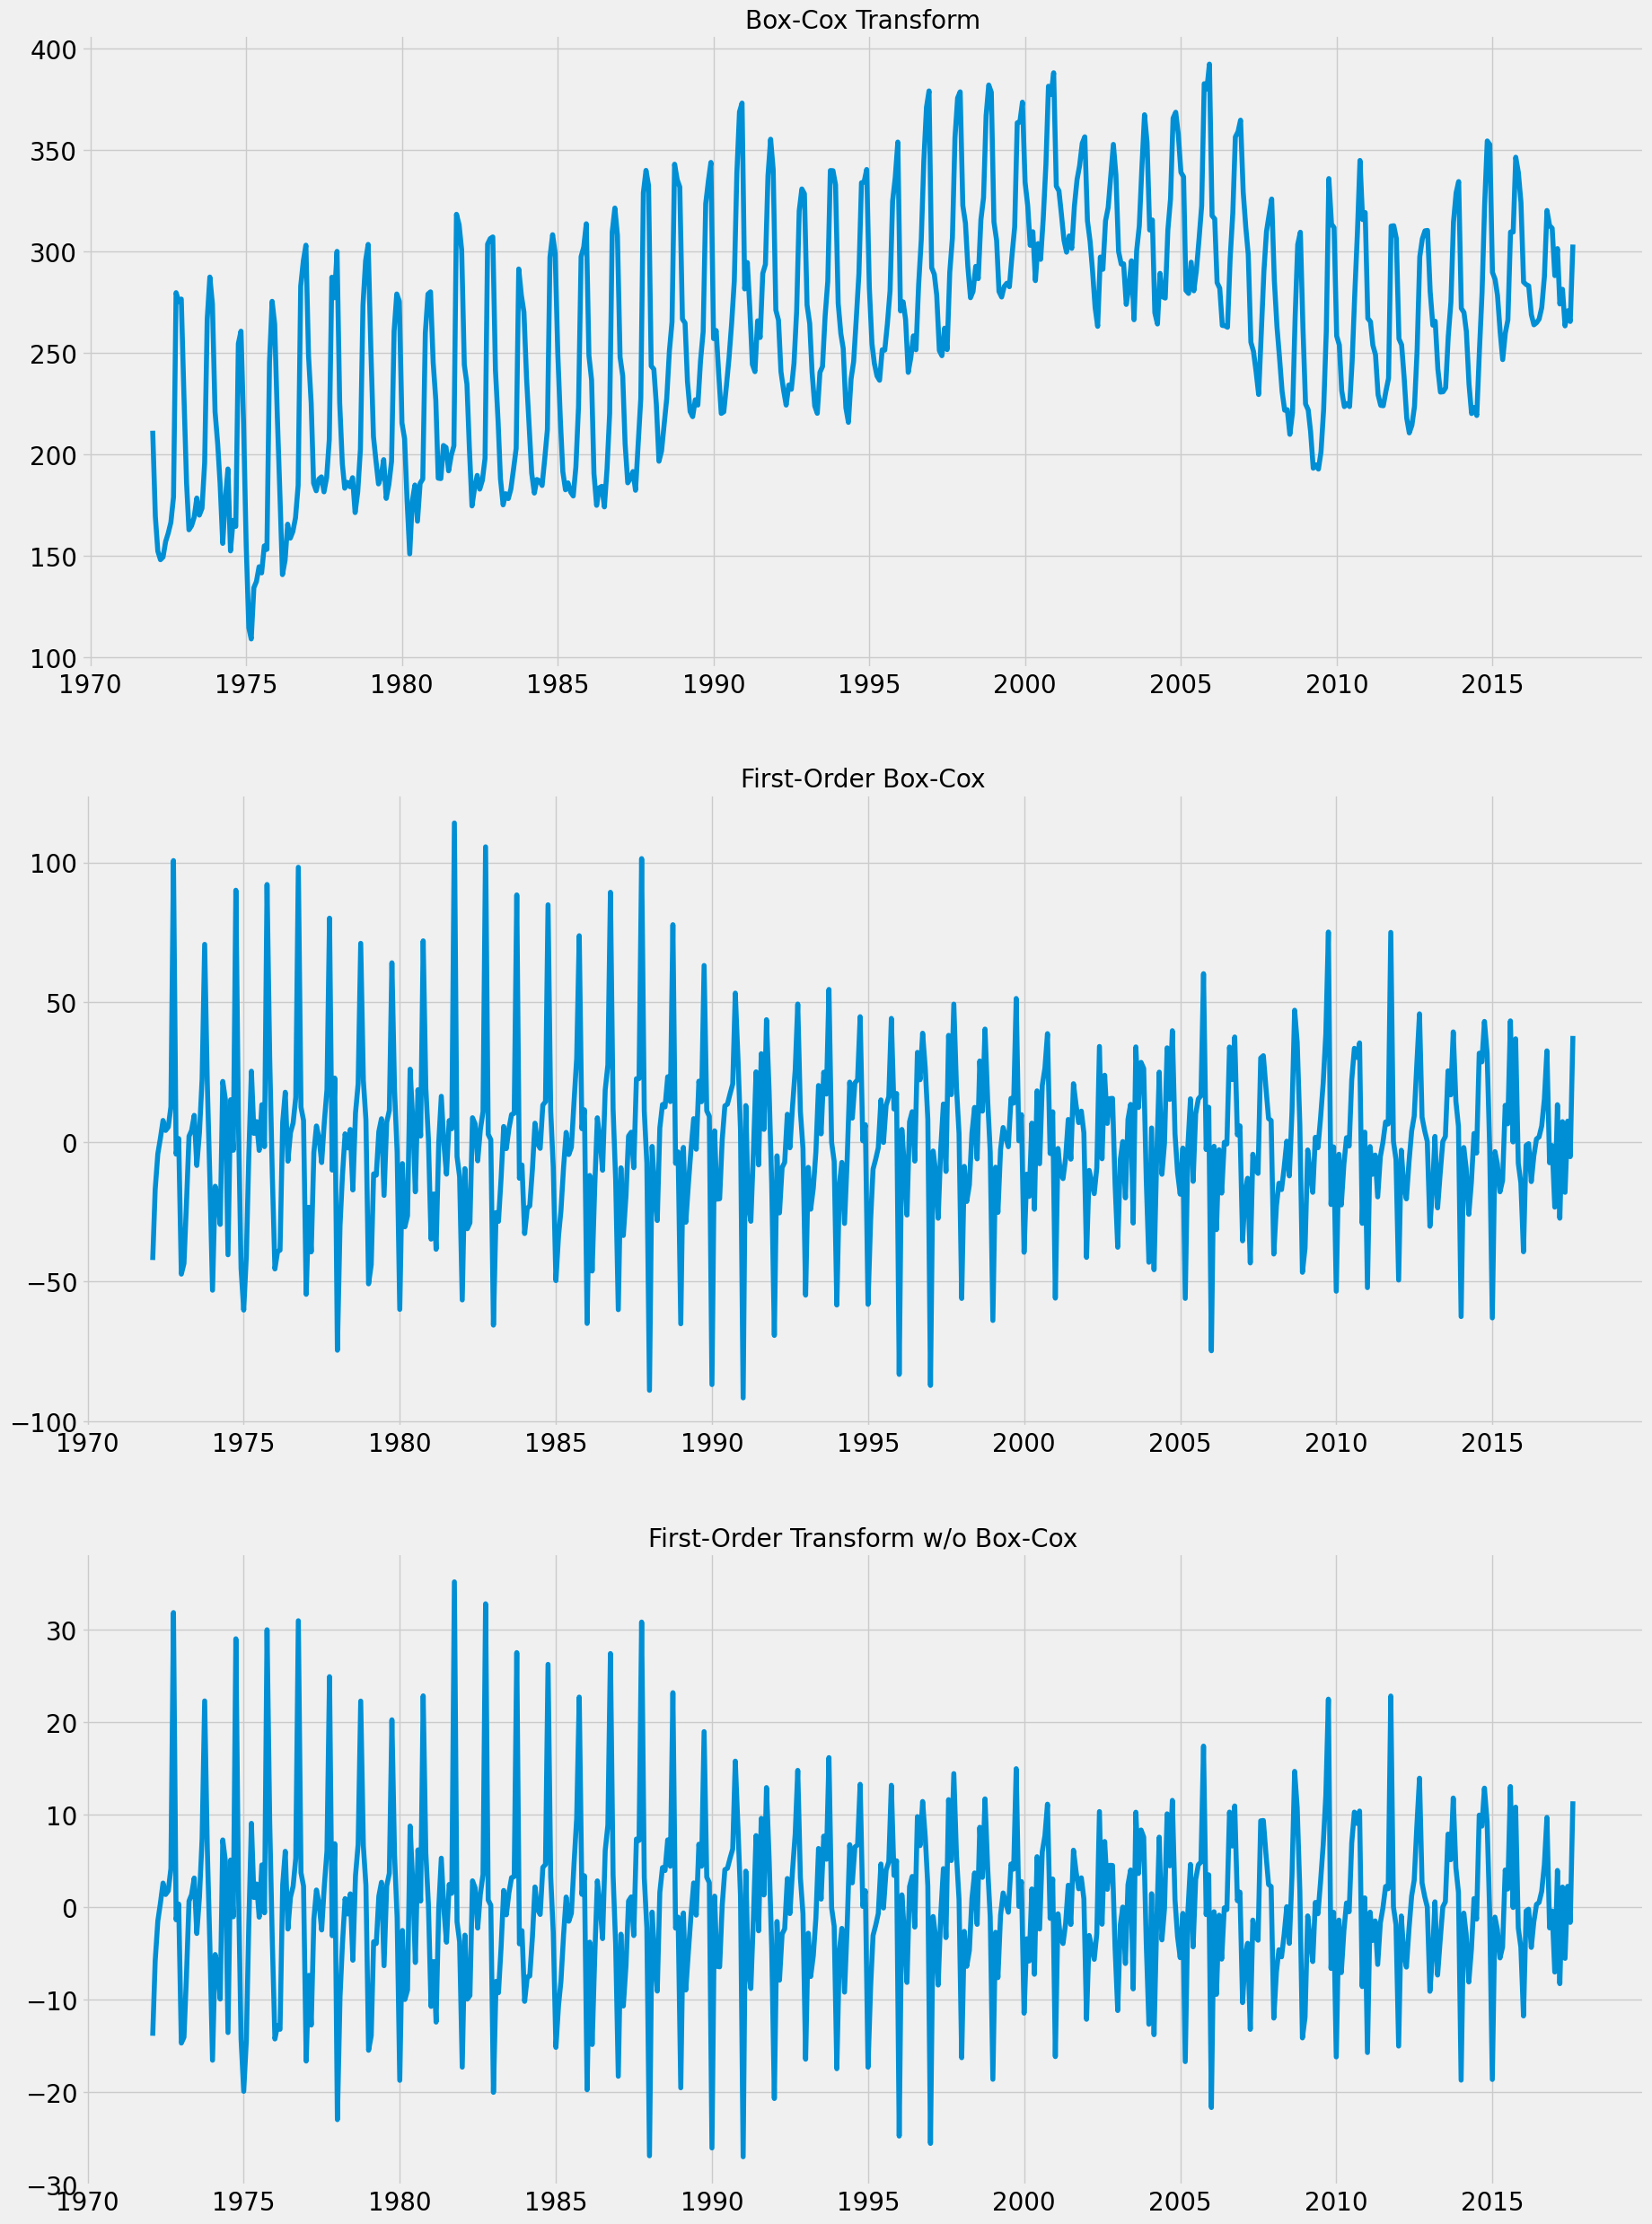

In [9]:
''' boxcox transformation '''

df['bc_prod'], lamb = boxcox(df.production)
df['df1_prod'] = df['bc_prod'].diff()
df['df_prod'] = df.production.diff()
fig = plt.figure(figsize=(20,40))

bc = plt.subplot(411)
bc.plot(df.bc_prod)
bc.title.set_text('Box-Cox Transform')

df1 = plt.subplot(412)
df1.plot(df.df1_prod)
df1.title.set_text('First-Order Box-Cox')

df2 = plt.subplot(413)
df2.plot(df.df_prod)
df2.title.set_text('First-Order Transform w/o Box-Cox')

df.bc_prod.dropna(inplace=True)
df.df1_prod.dropna(inplace=True)
df.df_prod.dropna(inplace=True)

print(f'Lambda Value {lamb}')

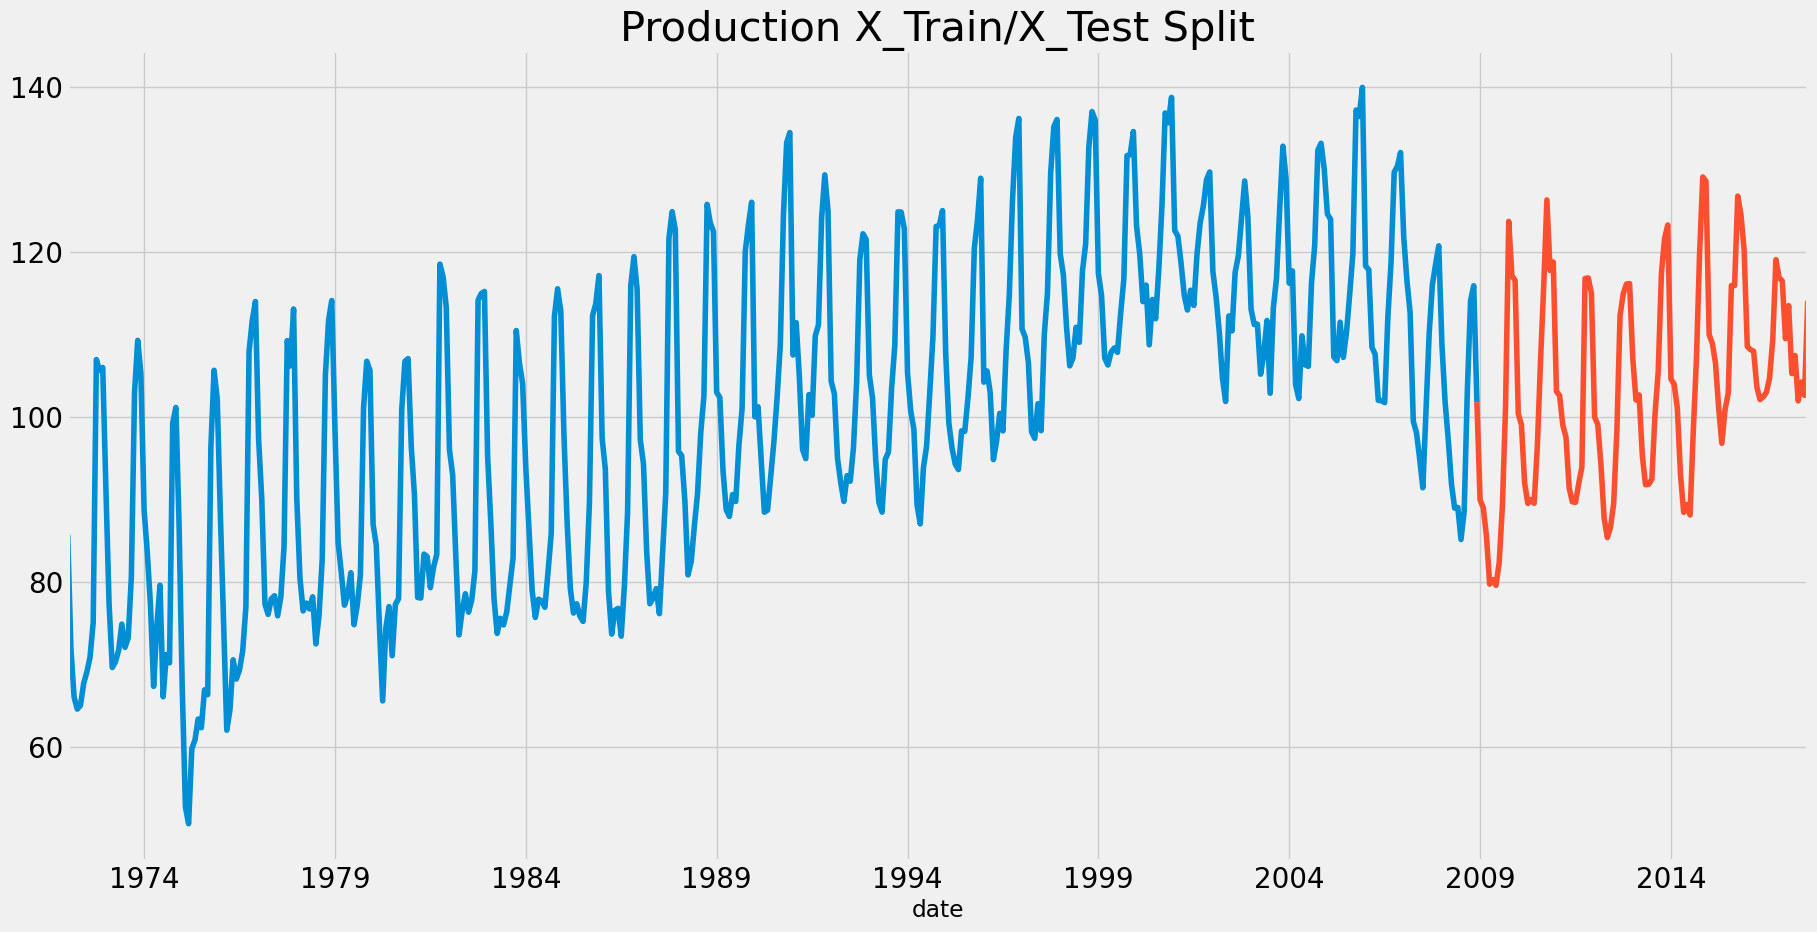

In [10]:
''' parameter estimation '''

dt = '2008-12-01'
X_train = df['production'].loc[:dt]
X_test = df['production'].loc[dt:]
X_train.plot(figsize=(20, 10), fontsize=20)
plt.title('Production X_Train/X_Test Split', fontsize=30)
X_test.plot()
plt.show()

In [11]:
''' SARIMAX model '''
model = model = SARIMAX(X_train, freq='MS', order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))

''' fit on data '''
model_fit = model.fit(disp=False) 


Mean Squared Error: 188.39297314745673
----------------------------------------------------------------------------------------------------

Root Mean Squared Error: 13.725631976250009
----------------------------------------------------------------------------------------------------

Mean Absolute Error: 11.376914841507157
----------------------------------------------------------------------------------------------------



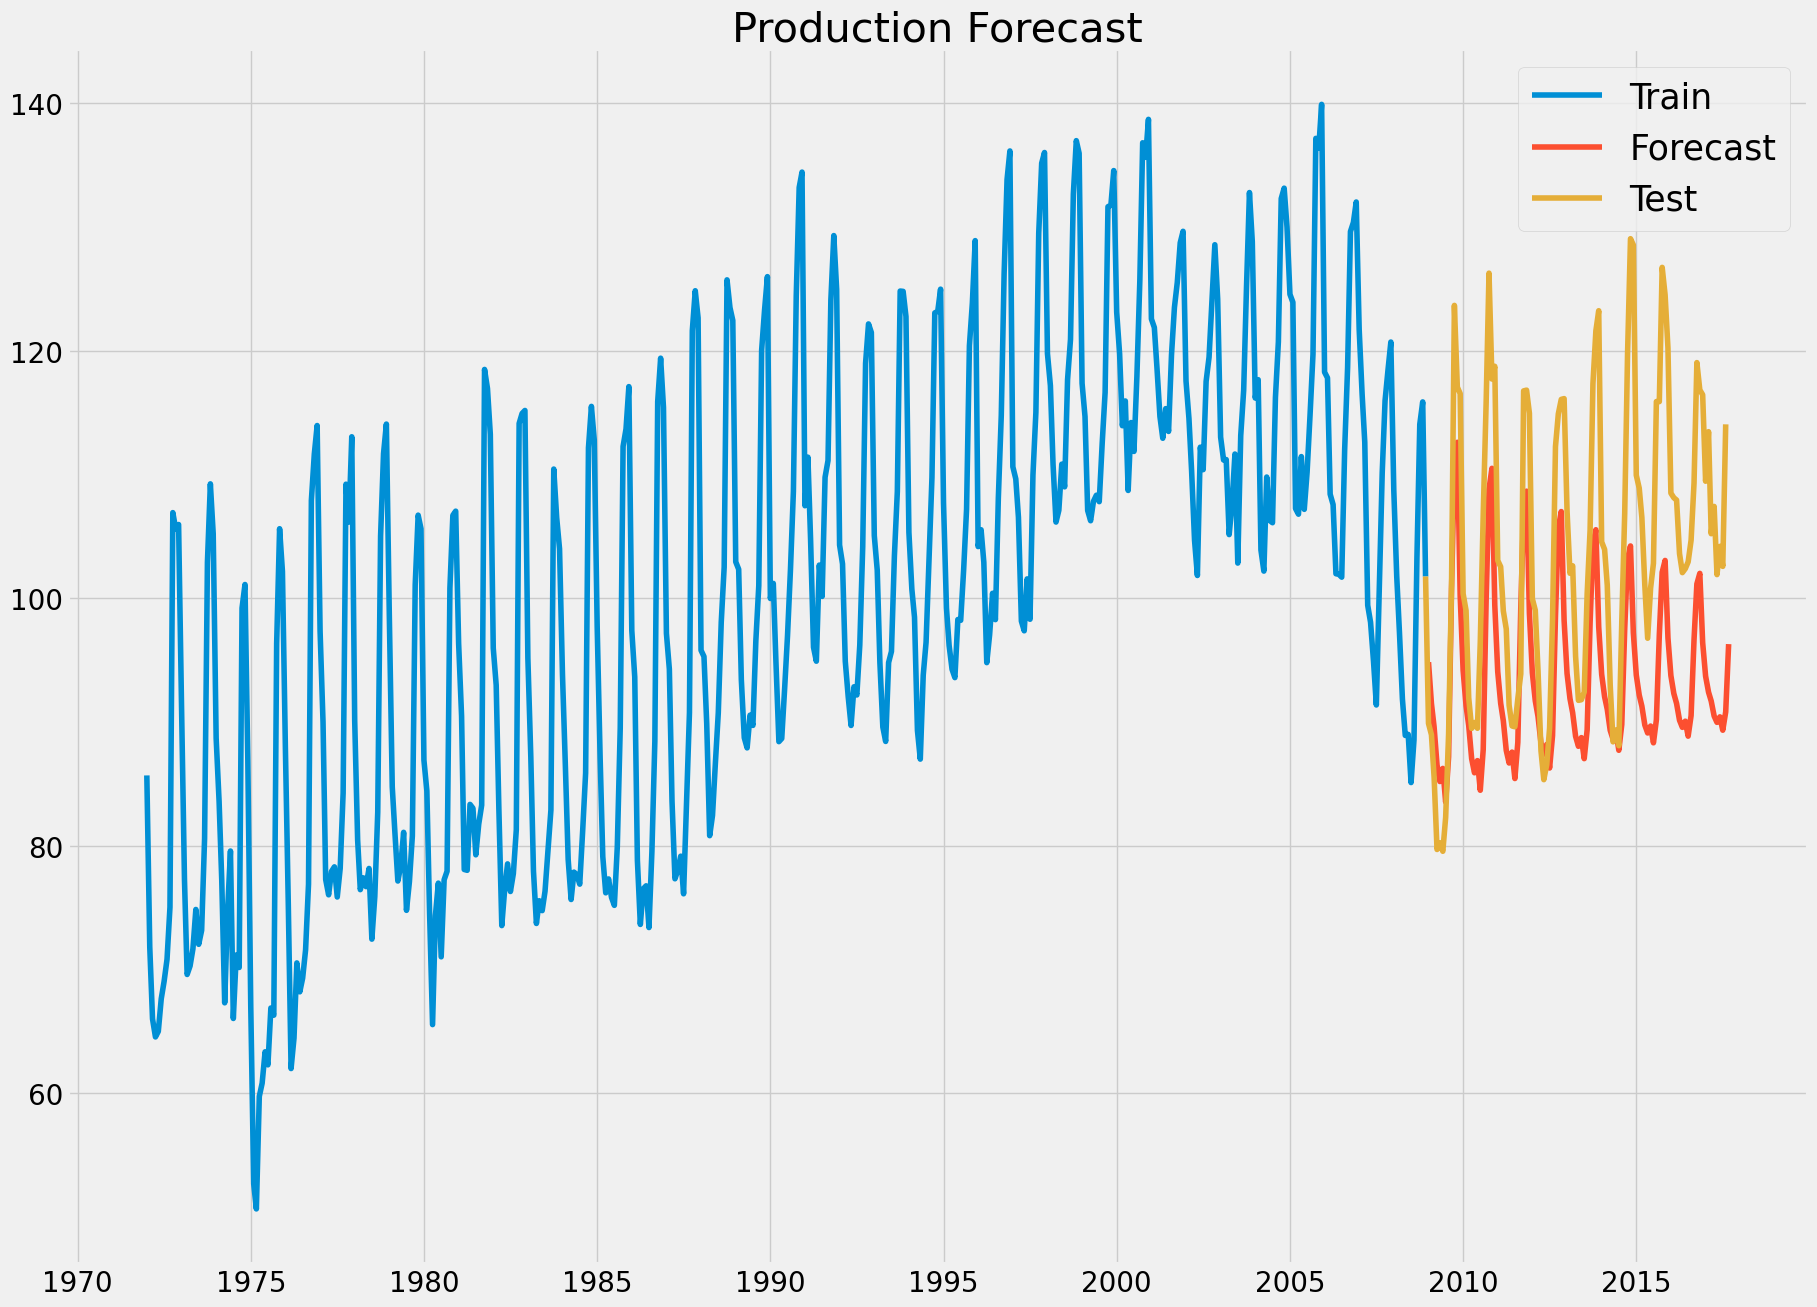

In [12]:
''' Model Measurements '''

forecast_len = len(X_test)
ffit = model_fit.forecast(forecast_len)

mse = mean_squared_error(X_test, ffit)
rmse = np.sqrt(mse)
mae = mean_absolute_error(X_test, ffit)

plt.figure(figsize=(20, 15))
plt.title('Production Forecast', fontsize=30)
plt.plot(X_train, label='Train')
plt.plot(ffit, label='Forecast')
plt.plot(X_test, label='Test')

print(f'Mean Squared Error: {mse}')
print("-" * 100)
print()

print(f'Root Mean Squared Error: {rmse}')
print("-" * 100)
print()

print(f'Mean Absolute Error: {mae}')
print("-" * 100)
print() 

plt.legend(fontsize=25)
plt.show()

In [13]:
''' Model Evaluation '''

def evaluation(X_train, X_test, order, season):
    history = [x for x in X_train]
    
    model = SARIMAX(history, order= order, seasonal_order= season)
    model_fit = model.fit(disp=False)
    
    pred = []
    res = {}
    ypred = model_fit.forecast()[0]
    pred.append(ypred)
    history.append(X_test[0])
    
    for i in range(1, len(X_test)):
        model = SARIMAX(history, order= order, seasonal_order= season)
        model_fit = model.fit(disp=False)
        ypred = model_fit.forecast()[0]
        pred.append(ypred)
        obs = X_test[i]
        history.append(obs)
    
    mse = mean_squared_error(X_test, pred)
    mae = mean_absolute_error(X_test, pred)
    rmse = math.sqrt(mse)
    
    pred = pd.Series(pred, index=X_test.index)
    res['pred'] = pred
    res['mse'] = mse
    res['rmse'] = rmse
    res['mae'] = mae
    
    return res

In [14]:
eva = evaluation(X_train, X_test, (1, 1, 1), (1, 0, 0, 12))

Mean Squared Error: 24.806844569145376
----------------------------------------------------------------------------------------------------

Root Mean Squared Error: 4.980647003065503
----------------------------------------------------------------------------------------------------

Mean Absolute Error: 3.719091722512153
----------------------------------------------------------------------------------------------------



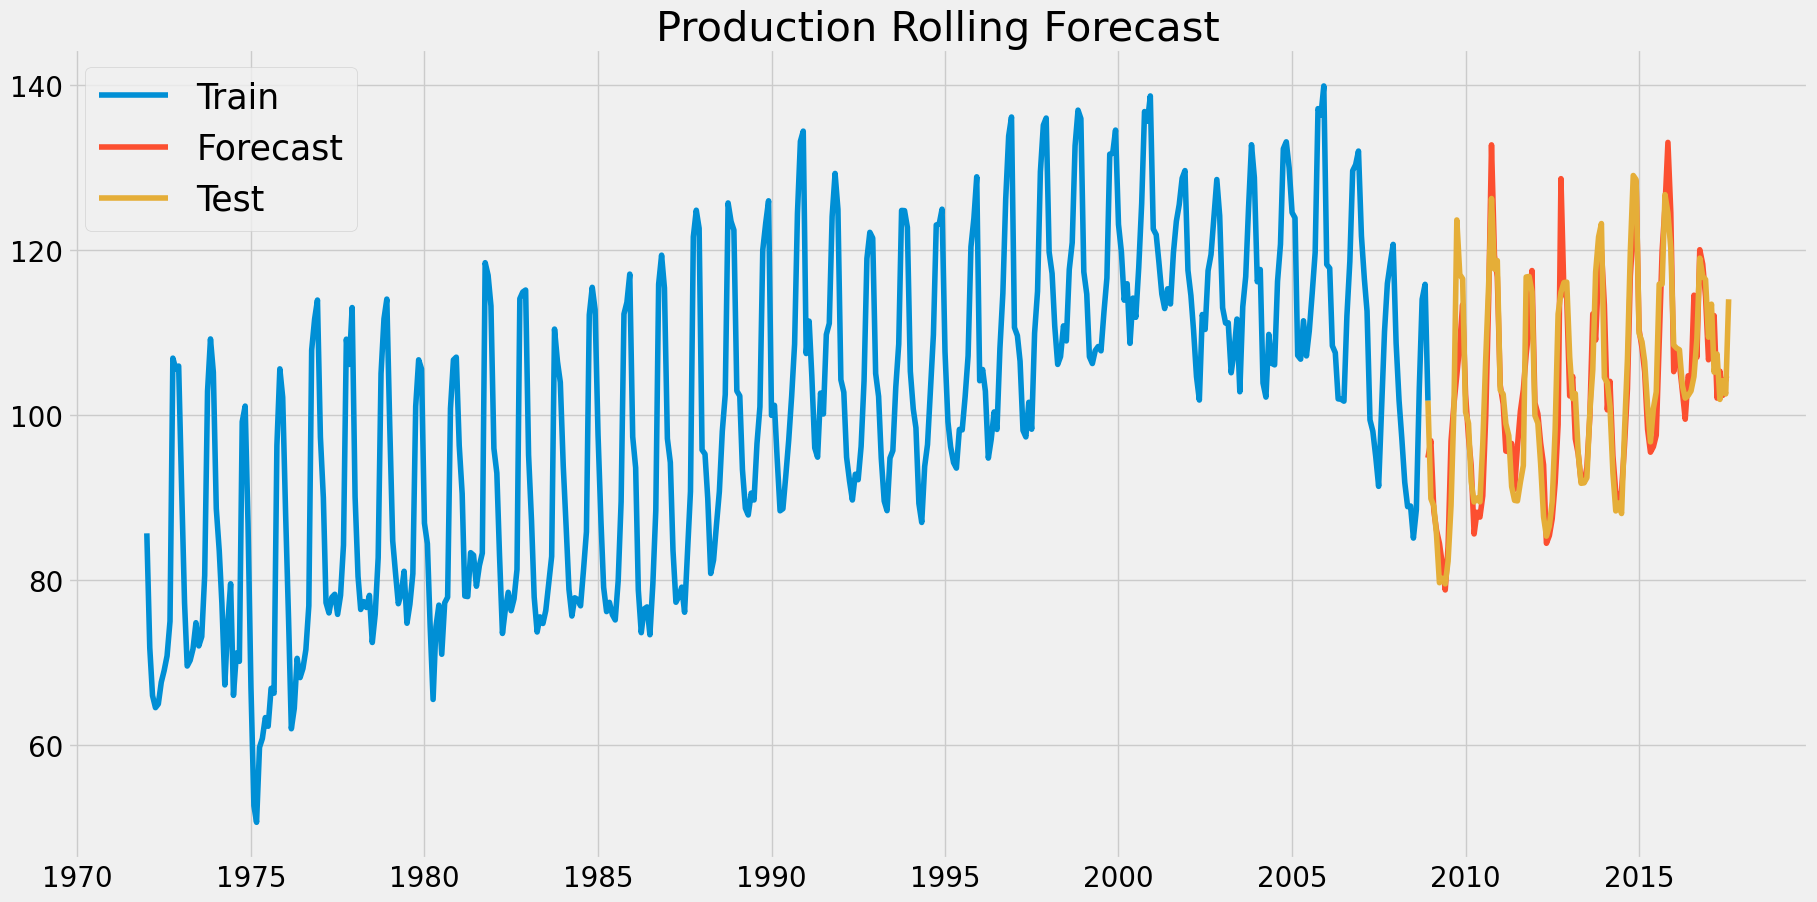

In [16]:
''' plotting production '''

plt.figure(figsize=(20, 10))
plt.title('Production Rolling Forecast', fontsize=30)
plt.plot(X_train, label='Train')
plt.plot(eva['pred'], label='Forecast')
plt.plot(X_test, label='Test')

print(f'Mean Squared Error: {eva["mse"]}')
print("-" * 100)
print()

print(f'Root Mean Squared Error: {eva["rmse"]}')
print("-" * 100)
print()

print(f'Mean Absolute Error: {eva["mae"]}')
print("-" * 100)
print()

plt.legend(['Train', 'Forecast', 'Test'], fontsize=25)
plt.show()